<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/roberta_ghosh_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 35.4 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [5]:
import torch.nn.functional as F

In [7]:
df_train = pd.read_csv("./drive/MyDrive/datasets/cleaned_ghosh_train_may22.csv")
df_train.head()

,type,Label,Tweet
0,TrainSen,0,05 really taught me a valuable lesson I am nev...
1,TrainSen,0,"Never had a voice to protest, so you fed me s..."
2,TrainSen,0,Rest in peace & love to you and your family
3,TrainSen,0,100 days until Christmas! 🌲 too soon not ready...
4,TrainSen,0,yay! Ca not wait to be reunited with you hun...


In [8]:
df_test= pd.read_csv("./drive/MyDrive/datasets/cleaned_ghosh_test_may22.csv")

In [10]:
df_val = pd.read_csv("./drive/MyDrive/datasets/cleaned_ghosh_dev_may22.csv")

In [11]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.0 MB/s 


In [12]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [13]:
df_train['emoji_list'] = df_train['Tweet'].apply(demoji_text)

In [14]:
f= list(filter(None, df_train['emoji_list']))

In [15]:
print(f)

[{'🌲': 'evergreen tree'}, {'😂': 'face with tears of joy'}, {'😂': 'face with tears of joy'}, {'😍': 'smiling face with heart-eyes'}, {'😩': 'weary face'}, {'😁': 'beaming face with smiling eyes', '😍': 'smiling face with heart-eyes', '🍴': 'fork and knife', '✊': 'raised fist', '🍗': 'poultry leg', '🌽': 'ear of corn', '😘': 'face blowing a kiss'}, {'✨': 'sparkles', '💫': 'dizzy'}, {'😭': 'loudly crying face'}, {'😭': 'loudly crying face'}, {'😴': 'sleeping face'}, {'☺': 'smiling face'}, {'🌪': 'tornado'}, {'☺️': 'smiling face'}, {'☺': 'smiling face'}, {'😂': 'face with tears of joy'}, {'😈': 'smiling face with horns', '😜': 'winking face with tongue', '😩': 'weary face'}, {'😂': 'face with tears of joy'}, {'❤️': 'red heart', '👶': 'baby', '😩': 'weary face'}, {'😍': 'smiling face with heart-eyes'}, {'😊': 'smiling face with smiling eyes'}, {'🎤': 'microphone'}, {'⚓': 'anchor', '❤️': 'red heart'}, {'❤': 'red heart'}, {'😂': 'face with tears of joy'}, {'🏈': 'american football'}, {'😘': 'face blowing a kiss'}, {'😭

In [16]:
all_keys = set().union(*(d.keys() for d in f))

In [17]:
print(all_keys)

{'👋', '🌌', '☕', '🎧', '🌧', '✂', '🆒', '✌', '🌎', '😮', '🏦', '😽', '🎺', '😂', '🐊', '🤐', '🌞', '➰', '🌿', '🅿️', '🔕', '🙍', '💓', '🕸', '🌲', '🔬', '🚔', '✌️', '⛄', '✅', '😛', '👓', '😣', '😇', '🚫', '🎁', '🆘', '😑', '💳', '🚬', '❓', '😰', '🎨', '🐮', '😾', '✋', '👦🏿', '💌', '🙊', '🤔', '😟', '🌯', '🐜', '🍸', '🇮🇹', '🐻', '😧', '😒', '🐀', '😹', '📻', '💸', '‼️', '☺', '🍾', '😙', '🔱', '✈️', '🌴', '👐', '🦄', '💁🏼', '💪', '☀', '💶', '👀', '🏿', '✝', '😄', '📤', '💩', '🔐', '🍓', '📥', '™', '🐅', '🌤', '🗽', '👈', '🚶', '👠', '🐥', '☁', '🌙', '🌬', '⭕', '🌨', '🐧', '💐', '😼', '💁🏽', '🐯', '🇨🇦', '🛏', '💦', '👍', '💣', '🔦', '❄', '😁', '💝', '💄', '🍆', '🐷', '☹️', '🔋', '😘', '🌟', '🍰', '🔥', '🙎', '🐏', '🍼', '🙇', '😔', '⛈', '👑', '☔', '🆙', '🐳', '🌽', '😅', '📵', '🎵', '®', '🖖', '😈', '⚡', '🚣', '👨\u200d👩\u200d👧\u200d👧', '😲', '📓', '🔊', '⛵', '🌍', '😫', '🌏', '✍', '🙏', '😻', '🚐', '💯', '➡', '🎙', '😆', '💫', '😍', '👸', '☺️', '🏐', '🌈', '🏹', '👎🏼', '⚽', '☁️', '🐘', '🎥', '🚪', '😎', '🏵', '🍑', '🌶', '📜', '♐', '☀️', '📖', '💋', '🎎', '♥️', '👶', '🙁', '👱', '🍁', '🐨', '😤', '🍕', '✨', '❄️', '🕑', '👉🏿', '🐔', '🔫', '

In [18]:
len(all_keys)

453

In [19]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [20]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#tokenizer.add_tokens(['⭕', '♐', '👋', '👴', '🤔', '😳', '✔', '🎶', '😂', '😪', '⛽', '😤', '🏋', '💌', '🌏', '♥', '🎙', '💐', '🏇', '☃', '👑', '📄', '🙁', '🐊', '🌸', '☹', '💦', '⏲', '🙏🏽', '😉', '🍅', '🎮', '📹', '😄', '🎉', '😩', '😮', '🍂', '🙎', '😟', '😫', '🔫', '🙏', '😀', '⚡', '💁', '😅', '👎', '®', '❄', '🌧', '😌', '🏹', '✏️', '👍', '⏳', '💸', '👦', '🏽', '😖', '👼', '🐥', '🐜', '🌊', '😼', '✂️', '😰', '🍝', '💀', '🍿', '🙇', '🚣', '💎', '😍', '🍋', '👲', '🙌🏼', '🔒', '🌟', '📜', '💋', '⚽', '☀', '👋🏻', '🌌', '🏵', '🍀', '🚊', '🍣', '😊', '👳', '🙃', '😒', '🍻', '🏦', '📻', '🙄', '👩', '🌲', '🍏', '😞', '🔋', '👉', '🐸', '🙆🏻', '🆓', '🔮', '🍦', '💝', '🆙', '🚛', '😆', '☕', '🏰', '🆗', '🐣', '🌰', '🤑', '🔦', '🕸', '👅', '🅰', '🌈', '🎼', '🌝', '❗', '🔴', '🚐', '🌎', '😋', '🍟', '🌵', '💁🏼', '✖', '🍰', '🍹', '💷', '🚮', '🍇', '✅', '🏈', '👧', '👎🏼', '🤕', '👐', '🔬', '™', '🚬', '🚌', '🐼', '🚂', '👱', '📝', '‼️', '🌙', '🖊', '🍕', '😘', '💕', '🍗', '🇸🇸', '👂', '💖', '📈', '🏐', '⛄', '♥️', '🍸', '👿', '🎅', '🐱', '🤐', '🚜', '🐨', '🍚', '🎭', '⏱', '🚲', '➰', '⛪', '🍒', '😸', '🙍', '💯', '😃', '🎨', '💲', '🔷', '🗽', '👒', '🍴', '😣', '👫', '🚙', '🙂', '💈', '👈', '🐅', '🍁', '📓', '😢', '👉🏿', '🈵', '💄', '🍫', '💙', '🐍', '⚠️', '🖖', '👆', '✍', '🍑', '⛷', '♈', '🐑', '😻', '🍾', '🍍', '🎈', '😗', '✒️', '🖼', '👗', '👨', '😝', '😾', '📥', '🐧', '🌳', '❤', '😚', '🎄', '👵', '👸🏽', '➡️', '✂', '😐', '😎', '💛', '👨\u200d👩\u200d👦\u200d👦', '⬆️', '©', '❌', '⚓', '🏡', '🚡', '😡', '😱', '📀', '⛵', '🐿', '😓', '😁', '🐘', '🍔', '⭐', '🐾', '🏒', '🍼', '🎯', '🐚', '😔', '❣', '🦃', '💧', '👍🏼', '🆒', '🐟', '💍', '💪', '🚗', '💓', '😽', '🖐', '😿', '💑', '😴', '🚫', '👀', '❄️', '🍃', '✌', '🐷', '🌪', '😹', '🔓', '🌺', '😈', '😛', '🌴', '☄', '🐳', '💗', '🌻', '🐀', '😨', '😙', '💶', '😑', '🐰', '🇪🇸', '🔐', '⛈', '😶', '🇮🇹', '❓', '😦', '🌼', '🌤', '🖕🏼', '➡', '🌨', '⛸', '👪', '📖', '🍎', '👸', '🐗', '🆘', '🗣', '🎁', '🌯', '🏥', '🐏', '🔕', '😧', '🕷', '☝️', '😕', '🇯🇵', '👓', '🔥', '🍵', '✨', '🔱', '📵', '📺', '💳', '🇺🇸', '👄', '💫', '🚑', '😲', '🎆', '🙀', '😜', '📱', '🌿', '❤️', '🍭', '✏', '☺', '⚫', '🎺', '🌍', '🛏', '🎵', '0⃣', '🚘', '💣', '🏃', '😇', '🚪', '🎂', '😥', '😠', '😺', '🔞', '☝', '🌃', '🔊', '🏆', '🎊', '🍥', '🚶', '☁️', '🐔', '☔', '😯', '🌠', '👙', '🎤', '🌬', '✌️', '☮', '🦄', '💵', '🍺', '🍆', '🗑', '📤', '🕰', '😷', '🐛', '🌅', '✊', '🚔', '☹️', '🍓', '🙏🏼', '👠', '🐯', '☁', '🗿', '🎇', '💟', '💻', '💞', '🇨🇦', '✝', '🎧', '✔️', '🐒', '💁🏽', '🐮', '🌂', '1️⃣', '🌽', '✈️', '✋', '💡', '🙌', '👨\u200d👩\u200d👧\u200d👧', '🕑', '🌶', '🎎', '👶', '💩', '🏏', '🏿', '☺️', '🌞', '🙈', '💜', '👌', '🇬🇧', '🐠', '👼🏿', '☣', '☀️', '👻', '🎑', '🎹', '😭', '🌀', '🙊', '👦🏿', '😏', '🅿️', '🐻', '🎥', '👔', '🚽'])


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df_train['Tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


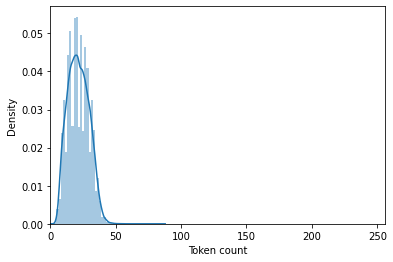

In [ ]:
import seaborn as sns

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [21]:
df_train_X= list(df_train["Tweet"])
df_val_X = list(df_val["Tweet"])

In [22]:
y_train = list(df_train["Label"])

y_val = list(df_val["Label"])

y_test = list(df_test["Label"])

In [23]:
X_train_tokenized = tokenizer(df_train_X, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(df_val_X, padding=True, truncation=True, max_length=512)

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [25]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [28]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)


    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [30]:
output_dir='./drive/MyDrive/savedmodel_meta/ghosh_roberta'

In [31]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    weight_decay = 0.01,
    logging_steps = 500,
    eval_steps = 500,
    logging_dir='./logs/ghosh_roberta_3',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    seed=123,
    load_best_model_at_end=True,
    #save_total_limit=1,
    learning_rate = 2e-5
)

In [32]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args= args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 39779
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19892


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.108300,0.248489,0.957962,0.438356,0.561404,0.492308
1000,0.072300,0.272786,0.962420,0.484848,0.561404,0.520325
1500,0.062700,0.291604,0.960510,0.463768,0.561404,0.507937
2000,0.060700,0.270510,0.957962,0.438356,0.561404,0.492308
2500,0.082600,0.262012,0.961146,0.470588,0.561404,0.512000
3000,0.081700,0.250213,0.963057,0.492308,0.561404,0.524590
3500,0.061100,0.375262,0.945223,0.344086,0.561404,0.426667
4000,0.067000,0.289141,0.957962,0.438356,0.561404,0.492308
4500,0.074300,0.310310,0.960510,0.463768,0.561404,0.507937
5000,0.068300,0.200400,0.968153,0.561404,0.561404,0.561404


***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-500
Configuration saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-500/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-1000
Configuration saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-1000/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.108300,0.248489,0.957962,0.438356,0.561404,0.492308
1000,0.072300,0.272786,0.962420,0.484848,0.561404,0.520325
1500,0.062700,0.291604,0.960510,0.463768,0.561404,0.507937
2000,0.060700,0.270510,0.957962,0.438356,0.561404,0.492308
2500,0.082600,0.262012,0.961146,0.470588,0.561404,0.512000
3000,0.081700,0.250213,0.963057,0.492308,0.561404,0.524590
3500,0.061100,0.375262,0.945223,0.344086,0.561404,0.426667
4000,0.067000,0.289141,0.957962,0.438356,0.561404,0.492308
4500,0.074300,0.310310,0.960510,0.463768,0.561404,0.507937
5000,0.068300,0.200400,0.968153,0.561404,0.561404,0.561404


***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13000
Configuration saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13000/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13000/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13000/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13500
Configuration saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13500/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-13500/pytorch_model.bin
tokenizer config file saved in ./drive/MyDri

TrainOutput(global_step=15000, training_loss=0.051170132764180504, metrics={'train_runtime': 2856.1852, 'train_samples_per_second': 55.709, 'train_steps_per_second': 6.965, 'total_flos': 5425987183610400.0, 'train_loss': 0.051170132764180504, 'epoch': 3.02})

In [33]:
X_test = list(df_test["Tweet"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized,y_test)

# Load trained model
model_path = "./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-11000"

model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-11000/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./drive/MyDrive/savedmodel_meta/ghosh_roberta/checkpoint-11000/pytorch_model.bin
All model checkpoint weights were

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0])) #chkpoint11000

              precision    recall  f1-score   support

           1       0.96      0.09      0.17       999
           0       0.52      1.00      0.68       975

    accuracy                           0.54      1974
   macro avg       0.74      0.54      0.42      1974
weighted avg       0.74      0.54      0.42      1974



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0])) #chkpoint5000

              precision    recall  f1-score   support

           1       0.71      0.80      0.75      1703
           0       0.77      0.67      0.72      1703

    accuracy                           0.74      3406
   macro avg       0.74      0.74      0.74      3406
weighted avg       0.74      0.74      0.74      3406



In [32]:
class_names = [1,0]

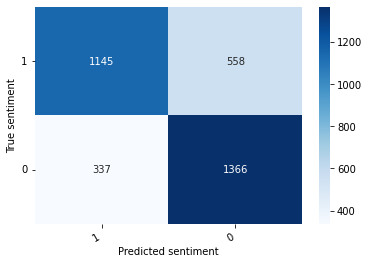

In [33]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)